# Aurora2
## 1. CNN을 이용한 문장 입력 이진분류 모델
## 2. 영화 리뷰 50000개를 입력 데이터로 사용
## 3. NLP와 Word2Vec 적용

# Dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
df = pd.DataFrame()
df = pd.read_csv('movie_data.csv', encoding='utf-8')

# Tokenizing

In [2]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stime1 = datetime.datetime.now()
print("tokenizing start...")

review_lines = list()
lines = df['review'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    
    tokens = [w.lower() for w in tokens]
    
    table = str.maketrans('', '', string.punctuation)
    
    stripped = [w.translate(table) for w in tokens]
    
    words = [word for word in stripped if word.isalpha()]
 
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)
    

etime1 = datetime.datetime.now()
mtime1 = etime1-stime1

print("tokenizing complete")
print("종료시간: ",etime1,"\n소요시간: ",mtime1,'\n\n')

tokenizing start...
tokenizing complete
종료시간:  2021-03-07 17:49:32.167454 
소요시간:  0:03:36.782125 




# Word2Vec

In [3]:
import gensim 

EMBEDDING_DIM = 40

model = gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=3, workers=4, min_count=1)

words = list(model.wv.vocab)

filename = 'imdb_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

# Testing Word2Vec

In [4]:
print(model.wv.most_similar('horrible'))

print(model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man']))

print(model.wv.doesnt_match("woman king queen movie".split()))

print(model.similarity('boy', 'girl'))

[('terrible', 0.9643401503562927), ('awful', 0.9361155033111572), ('bad', 0.8692532777786255), ('pathetic', 0.8605937957763672), ('sucks', 0.8515067100524902), ('dreadful', 0.8395964503288269), ('horrendous', 0.8237969875335693), ('horrid', 0.8199545741081238), ('atrocious', 0.8172741532325745), ('sucked', 0.8026109337806702)]
[('unsurprised', 0.8664793968200684), ('factoids', 0.8514717817306519), ('romeo', 0.8504727482795715), ('haggerd', 0.8501615524291992), ('tarzan', 0.8472567200660706), ('typeface', 0.8470250368118286), ('princess', 0.8384085893630981), ('areshe', 0.8366364240646362), ('nearbiographical', 0.8360018730163574), ('accentsomeone', 0.8332093358039856)]
movie
0.90771943


c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
c:\users\samsung\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


# Data processing

In [5]:
import os

embeddings_index = {}
f = open(os.path.join('', 'imdb_embedding_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()


X_train = df.loc[:24999, 'review'].values
y_train = df.loc[:24999, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

total_reviews = X_train + X_test
max_length = 200

In [6]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

VALIDATION_SPLIT = 0.1

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  df['sentiment'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

Found 134095 unique tokens.
Shape of review tensor: (50000, 200)
Shape of sentiment tensor: (50000,)


In [7]:
EMBEDDING_DIM = 40
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(num_words)

134096


# Model

In [8]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.initializers import Constant


model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

model.add(embedding_layer)

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))


print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 40)           5363840   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          25728     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 98, 128)           16512     
_________________________________________________________________
dropout (Dropout)            (None, 98, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

# Training & Testing

In [9]:
stime2 = datetime.datetime.now()
print("training start")

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


hist= model.fit(X_train_pad, y_train, batch_size=64, epochs=5, validation_data=(X_test_pad, y_test), verbose=2)

etime2 = datetime.datetime.now()
mtime2 = etime2-stime2

print("training complete")
print("종료시간: ",etime2,"\n소요시간: ",mtime2,'\n\n')

loss, accuracy = model.evaluate(X_test_pad, y_test, batch_size=64)
print('Accuracy: %.2f' % (accuracy*100),'%')

training start
Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 - 36s - loss: 0.4381 - accuracy: 0.7915 - val_loss: 0.5730 - val_accuracy: 0.7354
Epoch 2/5
45000/45000 - 36s - loss: 0.3407 - accuracy: 0.8504 - val_loss: 0.3297 - val_accuracy: 0.8648
Epoch 3/5
45000/45000 - 37s - loss: 0.3000 - accuracy: 0.8730 - val_loss: 0.3288 - val_accuracy: 0.8612
Epoch 4/5
45000/45000 - 36s - loss: 0.2630 - accuracy: 0.8888 - val_loss: 0.3290 - val_accuracy: 0.8660
Epoch 5/5
45000/45000 - 37s - loss: 0.2289 - accuracy: 0.9056 - val_loss: 0.3692 - val_accuracy: 0.8458
training complete
종료시간:  2021-03-07 18:02:27.220041 
소요시간:  0:03:02.220083 


5000/5000 [==============================] - 1s 249us/sample - loss: 0.3692 - accuracy: 0.8458
Accuracy: 84.58 %


# Result

KeyError: 'acc'

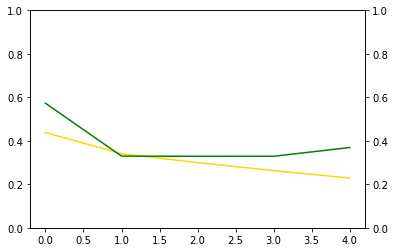

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'gold', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'r', label='val_acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left')
loss_ax.legend(loc='lower left')

plt.show()

In [11]:
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!" # 현제 모델의 한계: 특정 단어로 판별할 뿐, 앞 뒤 단어간 맥락을 완전히 읽지는 못한다.
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=200)

#predict
pred = model.predict(x=test_samples_tokens_pad)

pr_count=0
for i in pred :
    pr_count += 1
    print(pr_count)
    if i[0] >= 0.55 :
        print('positive')
    else :
        print('negative')
    print(i[0],'\n')

1
positive
0.84232014 

2
positive
0.6982778 

3
negative
0.42567056 

4
negative
0.35140663 

5
negative
0.45212618 

6
negative
0.06734211 

7
positive
0.6982778 

8
negative
0.1294273 

